# Engle-Granger method for stock selection
- use this method to select pairs of cointegrated stocks

In [2]:

import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np


#stocks = pd.read_csv("~/OneDrive/Desktop/Jakub/masterThesis/stocks.csv")

stocks = pd.read_csv("C:/Users/adamt/OneDrive - Wirtschaftsuniversität Wien - IT-SERVICES/Desktop/masterThesis/stocks.csv")

# example apple returns 
#plt.plot(np.log(stocks['AAPL']).diff())
#plt.show()

stocks

,Date,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
0,2015-02-06,36.229481,26.589561,37.547787,NaN,37.606339,19.021139,74.727798,72.540001,44.655716,...,101.623558,23.450714,126.668228,26.073265,59.627743,30.999655,44.225250,104.121887,87.150002,40.558193
1,2015-02-09,35.953190,26.766184,36.610725,NaN,36.796349,18.945066,74.058098,72.330002,44.290413,...,101.465096,23.437271,128.582413,25.803127,59.666843,30.929192,43.734734,102.884796,87.430000,39.824318
2,2015-02-10,36.533386,27.280401,37.541183,NaN,37.126949,19.122570,74.193741,72.760002,45.085968,...,101.849976,23.686100,133.952667,26.467541,59.308430,31.175842,44.314987,104.946602,88.089996,40.790417
3,2015-02-11,36.220264,27.919825,37.409218,NaN,37.135231,19.097212,74.566727,73.010002,45.150906,...,108.392456,23.605391,132.282089,25.956448,59.041264,31.052504,44.261143,104.794197,88.269997,42.518269
4,2015-02-12,36.855713,28.273067,37.646767,NaN,37.374916,18.888014,75.524673,74.589996,46.043854,...,109.524361,23.914755,135.325867,25.941849,60.194702,31.369652,44.745689,105.914742,89.470001,42.536839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2511,2025-01-31,151.520004,236.000000,183.899994,131.169998,127.930000,93.070000,384.950012,437.450012,211.889999,...,329.570007,30.620001,86.849998,67.199997,106.830002,124.040001,130.500000,109.480003,391.940002,170.899994
2512,2025-02-03,148.630005,228.009995,190.139999,129.779999,128.449997,93.099998,385.209991,438.600006,205.240005,...,330.670013,30.750000,83.559998,67.750000,107.089996,122.800003,131.500000,108.160004,386.089996,171.940002
2513,2025-02-04,147.039993,232.800003,189.949997,130.740005,129.100006,92.769997,391.619995,440.230011,206.009995,...,320.309998,30.139999,83.190002,67.320000,109.959999,129.240005,131.470001,107.800003,383.459991,172.240005
2514,2025-02-05,147.990005,232.470001,191.750000,129.600006,132.059998,93.059998,398.250000,437.630005,209.800003,...,320.649994,30.340000,81.660004,67.949997,109.879997,129.809998,131.250000,108.250000,388.040009,175.669998


- Step 1: Regression of Stock 1 on Stock 2
    - absolute or relative regression
    - Y = \beta X + \epsilon

- Step 2: Perform a Dickey-Fuller test on the residuals (check for stationarity) (Engle and Granger, 1987)(Hossein, 2016)

In [4]:
#%pip install statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import warnings
import math 
#%pip install tqdm
from tqdm import tqdm

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

result = []

midpoint = len(stocks.columns) // 2 

first_half_stocks = stocks.columns[:midpoint]
second_half_stocks = stocks.columns[midpoint:]


for stock1 in tqdm(first_half_stocks):
    for stock2 in second_half_stocks:
        if (stock1 == stock2) or (stock1 == "Date") or (stock2 == "Date"):
            continue 

        # Step 1: OLS of stock1 on stock2
        data = pd.concat([stocks[stock1], stocks[stock2]], axis=1).dropna()  # Drop NaN values
        x = sm.add_constant(data[stock1])  # Add constant after dropping NaNs
        y = data[stock2] 

        try:
            model = sm.OLS(y,x).fit()
        except Exception as e:
            print(f"Error during OLS fit: {e}")

        ols_pvalue = model.pvalues[1]
        
        # if there is no linear relationship
        if ols_pvalue > 0.001 or math.isnan(ols_pvalue): 
            continue 

        # Step 2 : dickey Fuller test of the residuals
        residuals = pd.Series(model.resid)

        # if stationary, append to list as cointegrated pair
        try:
            adf_pvalue = adfuller(residuals)[1]
        except Exception as e:
            print(f"Error during ADF test: {e}")

        if  adf_pvalue < 0.001 and not np.isnan(adf_pvalue):
            #print("Match Found", stock1, " and ", stock2, "p value and adf p value: ", adf_pvalue, ols_pvalue)
            result.append({
                "pair": (stock1, stock2),
                "residuals": residuals,  # Residuals
                "beta": model.params  # Beta coefficient(s)
            })



result = pd.DataFrame(result)
result.to_csv("C:/Users/adamt/OneDrive - Wirtschaftsuniversität Wien - IT-SERVICES/Desktop/masterThesis/pairs3.csv")
result

 23%|██▎       | 58/252 [37:55<1:36:34, 29.87s/it]

Error during OLS fit: zero-size array to reduction operation maximum which has no identity
Error during OLS fit: zero-size array to reduction operation maximum which has no identity
Error during OLS fit: zero-size array to reduction operation maximum which has no identity
Error during OLS fit: zero-size array to reduction operation maximum which has no identity
Error during OLS fit: zero-size array to reduction operation maximum which has no identity
Error during OLS fit: zero-size array to reduction operation maximum which has no identity
Error during OLS fit: zero-size array to reduction operation maximum which has no identity
Error during OLS fit: zero-size array to reduction operation maximum which has no identity
Error during OLS fit: zero-size array to reduction operation maximum which has no identity
Error during OLS fit: zero-size array to reduction operation maximum which has no identity
Error during OLS fit: zero-size array to reduction operation maximum which has no identity

 23%|██▎       | 59/252 [38:25<1:36:39, 30.05s/it]

Error during OLS fit: zero-size array to reduction operation maximum which has no identity


 27%|██▋       | 68/252 [42:41<1:26:23, 28.17s/it]

Error during OLS fit: zero-size array to reduction operation maximum which has no identity
Error during OLS fit: zero-size array to reduction operation maximum which has no identity
Error during OLS fit: zero-size array to reduction operation maximum which has no identity
Error during OLS fit: zero-size array to reduction operation maximum which has no identity
Error during OLS fit: zero-size array to reduction operation maximum which has no identity
Error during OLS fit: zero-size array to reduction operation maximum which has no identity
Error during OLS fit: zero-size array to reduction operation maximum which has no identity
Error during OLS fit: zero-size array to reduction operation maximum which has no identity
Error during OLS fit: zero-size array to reduction operation maximum which has no identity
Error during OLS fit: zero-size array to reduction operation maximum which has no identity
Error during OLS fit: zero-size array to reduction operation maximum which has no identity

100%|██████████| 252/252 [2:04:19<00:00, 29.60s/it]  


,pair,residuals,beta
0,"(A, MTD)",0 -27.827557 1 -29.102378 2 ...,const -29.789757 A 10.116825 dtype: f...
1,"(A, TER)",0 1.069766 1 1.376809 2 1...,const -18.762659 A 0.976204 dtype: f...
2,"(A, TSLA)",0 35.187631 1 35.908898 2 ...,const -114.226373 A 2.581583 dtype:...
3,"(AAPL, LOW)",0 -6.036862 1 -7.002810 2 -6...,const 40.156400 AAPL 0.975701 dtype: f...
4,"(AAPL, MPWR)",0 -10.303191 1 -11.642558 2 -11...,const -31.877288 AAPL 3.241546 dtype: f...
...,...,...,...
439,"(IR, URI)",570 49.309471 571 42.799658 572 40...,const -126.437165 IR 8.886006 dtype:...
440,"(IR, VMC)",570 19.310992 571 19.551283 572 17...,const 53.216945 IR 2.242708 dtype: f...
441,"(IRM, JNPR)",0 -3.603303 1 -3.665098 2 -3.71...,const 17.256967 IRM 0.204642 dtype: f...
442,"(IRM, PANW)",0 -14.937730 1 -13.598594 2 -13...,const -6.739336 IRM 1.873722 dtype: flo...


# Example
- should the normalized spread be used ?
- absolute price regression is used since we want a price relationship 

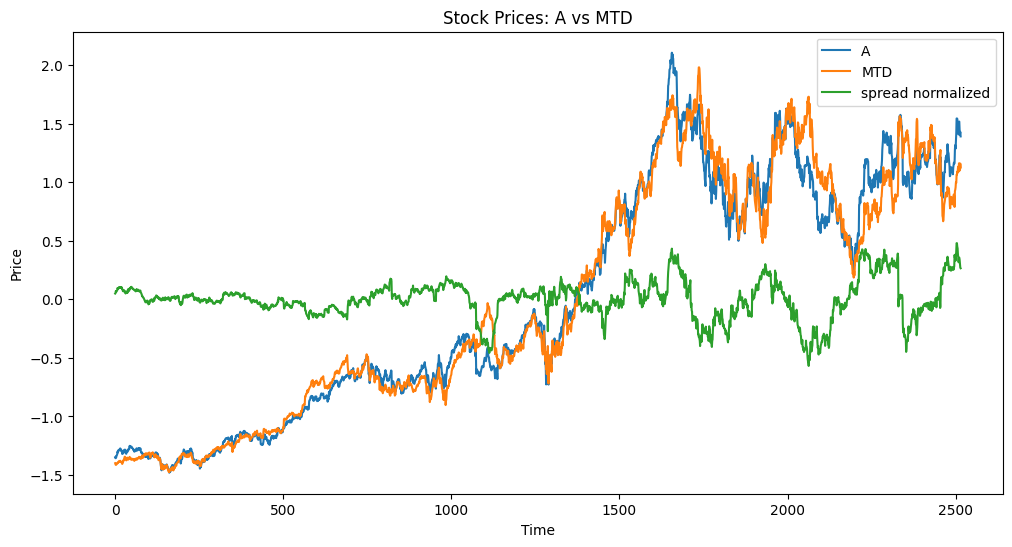

: 

In [ ]:
pairs = pd.read_csv("C:/Users/adamt/OneDrive - Wirtschaftsuniversität Wien - IT-SERVICES/Desktop/masterThesis/pairs2.csv", index_col = 0)

pairs = pairs.reset_index(drop=True)

ticker1,ticker2  = pairs.iloc[0]

stock1, stock2 = stocks[ticker1],stocks[ticker2]

normalized_stock1 = (stock1 - stock1.mean()) / stock1.std()

normalized_stock2 = (stock2 - stock2.mean()) / stock2.std()

# Calculate the spread between normalized stocks
normalized_spread = normalized_stock1 - normalized_stock2




plt.figure(figsize=(12,6))
plt.plot(normalized_stock1, label=ticker1)
plt.plot(normalized_stock2, label=ticker2)
plt.plot(normalized_spread, label = "spread normalized")


plt.legend()
plt.title(f"Stock Prices: {ticker1} vs {ticker2}")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()